# Projeto Mnist

In [56]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


## Variáveis

In [45]:
test_size = 0.2
random_state = 42
patience = 5

## Preparação dos dados

In [46]:
mnist = datasets.fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist["data"], mnist["target"]

X = X.astype(np.float32)
y = y.astype(np.int64)

X = X / 255.0

X = X.reshape(-1, 28, 28, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((56000, 28, 28, 1), (56000,), (14000, 28, 28, 1), (14000,))

## Construção do Modelo

In [47]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_5 (Dropout)         (None, 1600)             

In [48]:
#tf.debugging.set_log_device_placement(True)
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6823994998451644669
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5653921792
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16283259672793205134
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 5050, pci bus id: 0000:01:00.0, compute capability: 12.0"
 xla_global_id: 416903419]

In [49]:
es_loss_val = keras.callbacks.EarlyStopping(monitor='val_loss',mode = min, patience=patience, restore_best_weights=True)
es_val = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = max, patience=patience, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10*patience, batch_size=32, validation_data=(X_test, y_test),verbose = 1 ,callbacks=[es_loss_val, es_val])

Epoch 1/50
1750/1750 [==============================] - 6s 3ms/step - loss: 0.2423 - accuracy: 0.9251 - val_loss: 0.0584 - val_accuracy: 0.9821
Epoch 2/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0907 - accuracy: 0.9726 - val_loss: 0.0460 - val_accuracy: 0.9854
Epoch 3/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0700 - accuracy: 0.9788 - val_loss: 0.0375 - val_accuracy: 0.9884
Epoch 4/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0560 - accuracy: 0.9829 - val_loss: 0.0360 - val_accuracy: 0.9891
Epoch 5/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0508 - accuracy: 0.9845 - val_loss: 0.0348 - val_accuracy: 0.9891
Epoch 6/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0434 - accuracy: 0.9868 - val_loss: 0.0360 - val_accuracy: 0.9895
Epoch 7/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0408 - accuracy: 0.9873 - val_loss: 0.0289 - val_accuracy:

In [ ]:
model.save("C:\Users\rodri\Desktop\projetoIa\model")

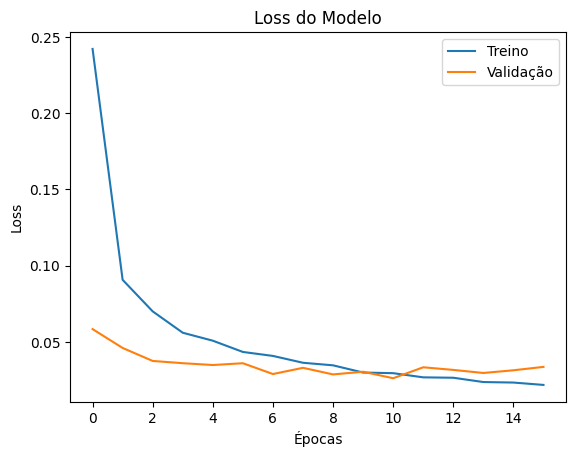

In [50]:

plt.figure()
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss do Modelo')
plt.legend()
plt.show()

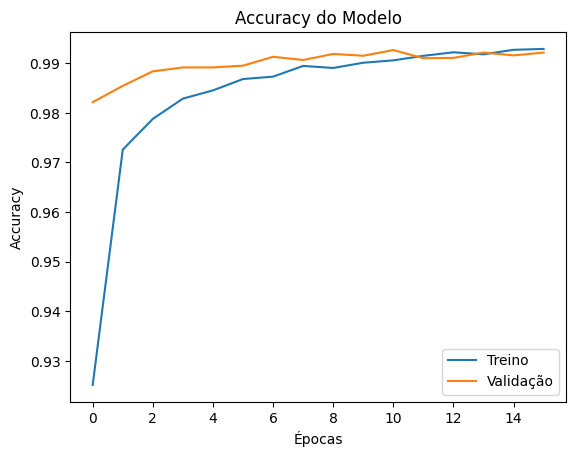

In [51]:
plt.figure()
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Accuracy do Modelo')
plt.legend()
plt.show()

In [54]:

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

438/438 [==============================] - 1s 1ms/step


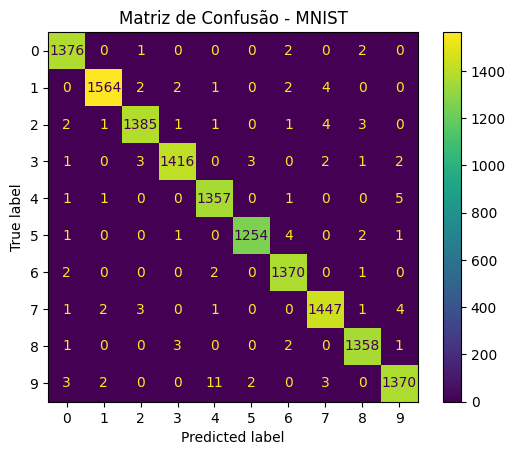

In [57]:
cm = confusion_matrix(y_test, y_pred)

labels = list(range(10))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)
disp.plot()
plt.title("Matriz de Confusão - MNIST")
plt.show()